huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Processing batch 1/1
Processing batch 1/1
Processing batch 1/1


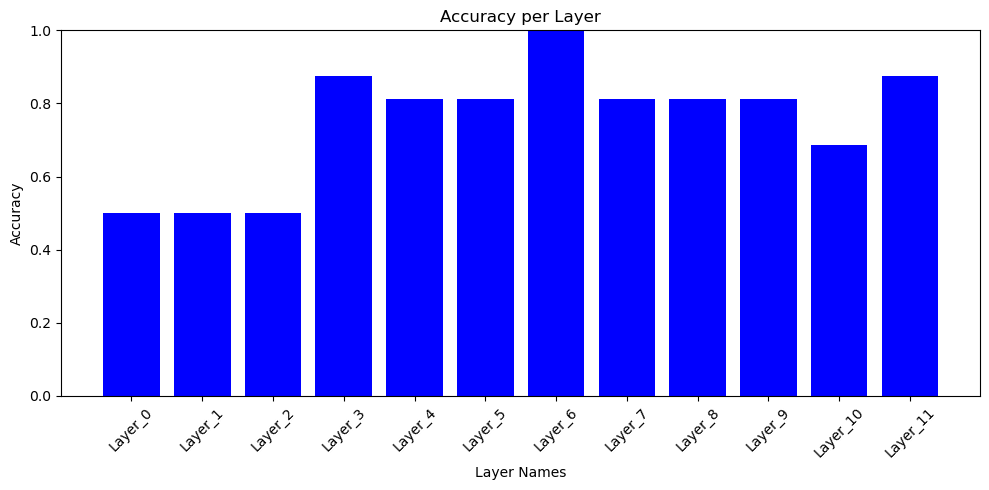

Accuracy for layer Layer_0: 0.50%
Accuracy for layer Layer_1: 0.50%
Accuracy for layer Layer_2: 0.50%
Accuracy for layer Layer_3: 0.88%
Accuracy for layer Layer_4: 0.81%
Accuracy for layer Layer_5: 0.81%
Accuracy for layer Layer_6: 1.00%
Accuracy for layer Layer_7: 0.81%
Accuracy for layer Layer_8: 0.81%
Accuracy for layer Layer_9: 0.81%
Accuracy for layer Layer_10: 0.69%
Accuracy for layer Layer_11: 0.88%


In [9]:
import numpy as np
import torch
import random
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

import utils

import wandb
wandb.init(project='Exploring direction detector', entity='paul-colognese')

# Global variables
num_test_samples = 16 # Number of samples to test the detector
num_detector_samples = 16 # Number of samples to construct the detector
batch_size = 128 # Batch size for detector construction
max_length = None # If none, uses maximum length of the dataset
model_name = "openai-community/gpt2" #"meta-llama/Llama-2-7b-hf"

# Load model and dataset
model = utils.HookedModel(model_name)
model.set_layers(model.model.transformer.h)

# Get dataset for constructing direction detector
dataset = utils.Dataset()
dataset.load_data('datasets/ilikecats_20000.csv', 'Animal', 'Non-Animal')

# Get dataset for testing direction detector
test_dataset = dataset = utils.Dataset()
test_dataset.load_data('datasets/ilikecats_20000.csv', 'Animal', 'Non-Animal')
test_data, labels = test_dataset.combine_dataset_get_labels(num_test_samples)

# Configuration for wandb
config = wandb.config
config.batch_size = batch_size
config.max_length = max_length  # Dynamically set based on dataset if needed
config.num_test_samples = num_test_samples
config.num_detector_samples = num_detector_samples
config.model_name = model_name
config.dataset_size = min(len(dataset), num_detector_samples) # Assuming dataset is iterable and has length

# Construct direction detector vector
animal_detection_vectors = model.calculate_detector_direction(dataset, num_detector_samples, max_length, batch_size)

# Create test activations dataset
test_activations = model.get_last_token_activations(test_data, max_tokens = max_length, batch_size = batch_size)

# Evaluate detector
accuracies = utils.evaluate_detector(test_activations, animal_detection_vectors, labels, model.layer_indices_to_track)
# wandb.log(accuracies)
# Log all accuracies at once in a structured format for a single plot per run
accuracy_list = [{"Layer": layer_name, "Accuracy": accuracy} for layer_name, accuracy in accuracies.items()]
wandb.log({"Accuracy by Layer": wandb.Table(dataframe=pd.DataFrame(accuracy_list))})

for layer_name, accuracy in accuracies.items():
    # wandb.log({layer_name: accuracy})
    print(f"Accuracy for layer {layer_name}: {accuracy:.2f}%")